# Continuous Variable VQE for long-range molecular interactions

In the following, we illustrate how our code can be used to study the system composed of a pair of QDO oscillators. We focus on a 1-dimensional model for efficiency, but the code generalized to the full-fledged 3d QDO model.

We focus on the case of a diatomic system.

## Imports

In [4]:
from datetime import datetime
from dataclasses import dataclass
import json
import matplotlib.pyplot as plt
%matplotlib inline
from typing import Optional
import numpy as np
import os
import strawberryfields as sf
import tensorflow as tf

from src.energy_surface import EnergySurface

from src.utils import \
    von_neumann_entropy, \
    renyi_entropy, \
    make_gif, \
    plot_entropy, \
    plot_binding_entropy, \
    plot_binding_curve, \
    plot_wigner, \
    plot_joint_density

In [2]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

Let us define the following `Atom` dataclass to store the QDO parameters later

In [3]:
@dataclass
class Atom:
    m: float
    omega: float
    q: float

You can choose among the following list of atoms. Note that the 'Un' atom corresponds to a fictitious atom with unit parameters.

In [4]:
ATOMIC_PARAMETERS = {
    'Un': {'omega': 1.0000, 'm': 1.0000, 'q': 1.0000},
    'H':  {'omega': 0.4280, 'm': 0.8348, 'q': 0.8295},
    'Ne': {'omega': 1.1933, 'm': 0.3675, 'q': 1.1820},
    'Ar': {'omega': 0.6958, 'm': 0.3562, 'q': 1.3835},
    'Kr': {'omega': 0.6122, 'm': 0.3401, 'q': 1.4635},
    'Xe': {'omega': 0.5115, 'm': 0.3298, 'q': 1.5348},
}

## Preliminaries: defining the inputs of the simulation

Let us first define the various parameters relevant for the definition and the training of the model

In [5]:
args = {
    'layers': 8,
    'cutoff_dim': 5,
    'atom_list': ['Un', 'Un'],
    'active_sd': 0.0001,
    'passive_sd': 0.1,
    'learning_rate': 0.01,
    'epsilon': 1e-3,
    'patience': 30,
    'seed': 42,
    'save_dir': './logs/'
}

args['dimension'] = 1
args['modes'] = len(args['atom_list']) * args['dimension']

distances = list(np.linspace(0.1, 3.5, 70))
thetas = list(np.linspace(0.0, np.pi / 2, 20))

#distances = list(np.linspace(0.3, 3.5, 3))
#thetas = list(np.linspace(np.pi / 4, np.pi / 2, 2))

args['distance_list'] = distances
args['theta_list'] = thetas

args = objectview(args)

By default, Strawberry Fields sets $\hbar=2$. Let us redefine it to fit atomic units conventions

In [6]:
sf.hbar = 1.0

Let us also set the random seeds for reproducibility of the results

In [7]:
tf.random.set_seed(args.seed)
np.random.seed(args.seed)

Let us define a directory where to store the results of the simulation

Let us store the QDO's data into dataclass

In [8]:
atoms = []

for atom in args.atom_list:

    atoms.append(Atom(
        m=ATOMIC_PARAMETERS[atom]['m'],
        omega=ATOMIC_PARAMETERS[atom]['omega'],
        q=ATOMIC_PARAMETERS[atom]['q']
    ))

We work with the quadratures of the electromagnetic field, which are real valued variables, hence need to be discretized

In [9]:
x_quadrature_grid = np.linspace(-7.0, 7.0, 400)

## Training

We are finally ready to instanciate a `EnergySurface` object, whose ability is to run a VQE algorithm for each of the specified interatomic distances and angle/model, and store the results of the simulation in the directory defined previously.

In [ ]:
save_dir = os.path.join(
    args.save_dir,
    datetime.now().strftime("%Y.%m.%d.%H.%M.%S")
)

os.makedirs(save_dir, exist_ok=True)

# Save the parameters of the run to the log directory
with open(os.path.join(save_dir, 'args.json'), 'w') as f:
    json.dump(vars(args), f, indent=4)

energy_surface = EnergySurface(
    layers=args.layers,
    distance_list=distances,
    theta_list=thetas,
    x_quadrature_grid=x_quadrature_grid,
    atoms=atoms,
    active_sd=args.active_sd,
    passive_sd=args.passive_sd,
    cutoff_dim=args.cutoff_dim,
    learning_rate=args.learning_rate,
    save_dir=save_dir,
    verbose=False
)

res = energy_surface.construct_energy_surface_parallelized(
    epsilon=args.epsilon,
    patience=args.patience
)

## Postprocessing

### Loading and exporting data to mathematica

Let us load the results of the simulation

In [5]:
dir = 'logs/2023.02.21.13.19.23'
res = np.load(os.path.join(dir, 'results.npy'))
starting_distance = 0

binding_energies = res[:, starting_distance:, -1, -1]
states = res[:, starting_distance:, :-1, :-1]
distances = np.load(os.path.join(dir, 'distance_array.npy'))[starting_distance:]
thetas = np.load(os.path.join(dir, 'angle_array.npy'))
quadrature_grid = np.load(os.path.join(dir, 'quadrature_array.npy'))

entropy_array = von_neumann_entropy(states=states)
renyi_entropy_array = renyi_entropy(states=states, n=2)

with open(os.path.join(dir, 'args.json')) as f:
    args = json.load(f)

We export the data to Mathematica readable format in order to do interpolations and output beautiful plots

In [13]:
mathematica_dir = os.path.join('mathematica', dir.split('/')[1])
os.makedirs(mathematica_dir, exist_ok=True)

In [14]:
distances.astype('float32').tofile(os.path.join(mathematica_dir, 'distances.dat'))
thetas.astype('float32').tofile(os.path.join(mathematica_dir, 'angles.dat'))
binding_energies.astype('float32').tofile(os.path.join(mathematica_dir, 'binding_energies.dat'))
states.astype('complex').tofile(os.path.join(mathematica_dir, 'states.dat'))
quadrature_grid.astype('float32').tofile(os.path.join(mathematica_dir, 'quadrature_grid.dat'))
entropy_array.astype('float32').tofile(os.path.join(mathematica_dir, 'entropies.dat'))
renyi_entropy_array.astype('float32').tofile(os.path.join(mathematica_dir, 'renyi_entropies.dat'))

### Plotting the binding curve

In [33]:
startingDistance = [1, 2, 3, 5, 7, 8, 10, 12, 15, 18, 24, 22, 18, 17, 17, 16, 21, 25, 24] # starting at the first non-parallel angle

In [35]:
thetas

array([0.        , 0.08267349, 0.16534698, 0.24802047, 0.33069396,
       0.41336745, 0.49604095, 0.57871444, 0.66138793, 0.74406142,
       0.82673491, 0.9094084 , 0.99208189, 1.07475538, 1.15742887,
       1.24010236, 1.32277585, 1.40544935, 1.48812284, 1.57079633])

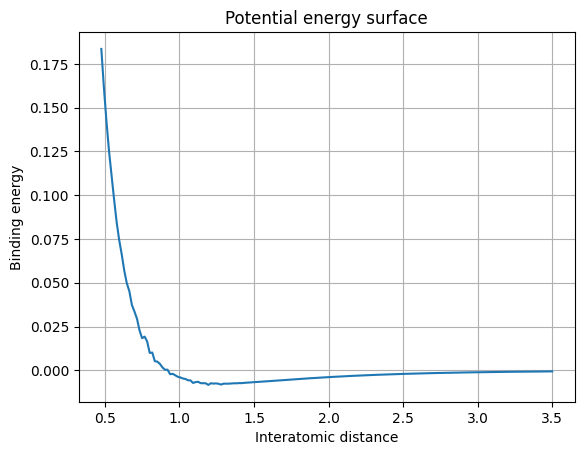

In [43]:
angle_idx = 12
start = startingDistance[angle_idx - 1]

plot_binding_curve(
    distance_array=distances[start:],
    binding_energy_array=binding_energies[angle_idx, start:]
)

In [31]:
thetas[8]

0.6613879270715354

### Entanglement entropy

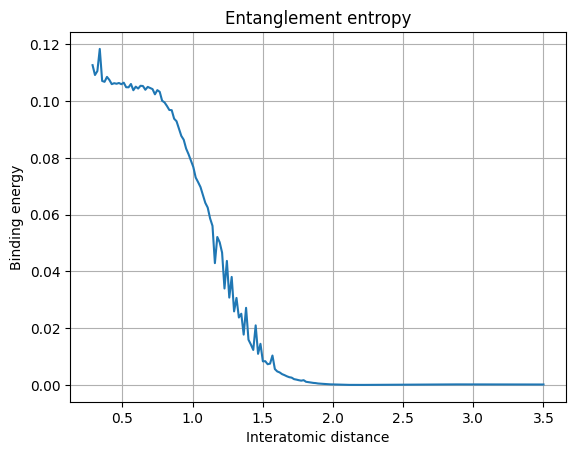

In [8]:
start = 11

plot_entropy(
    distance_array=distances[start:],
    entropy_array=entropy_array[8, start:]
)

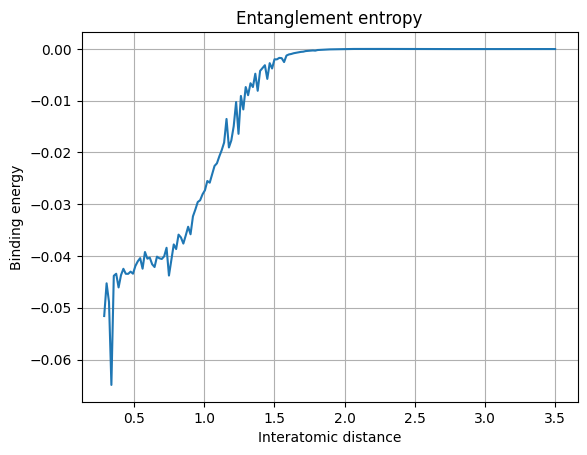

In [9]:
start = 11

plot_entropy(
    distance_array=distances[start:],
    entropy_array=renyi_entropy_array[8, start:]
)

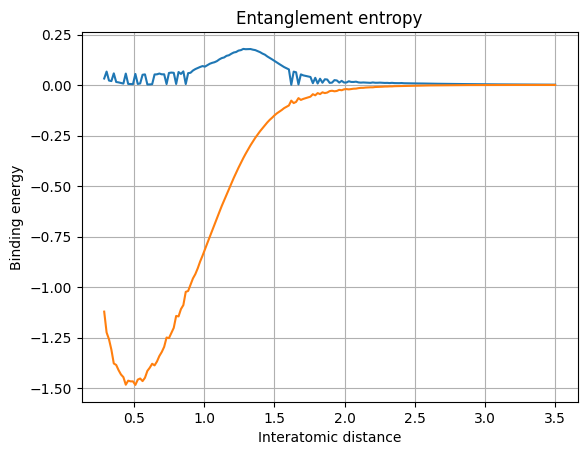

In [28]:
start = 11
angle = 4

plot_binding_entropy(
    distance_array=distances[start:],
    binding_energy_array=binding_energies[angle, start:],
    entropy_array=entropy_array[angle, start:]
)

### Wigner functions vizualization

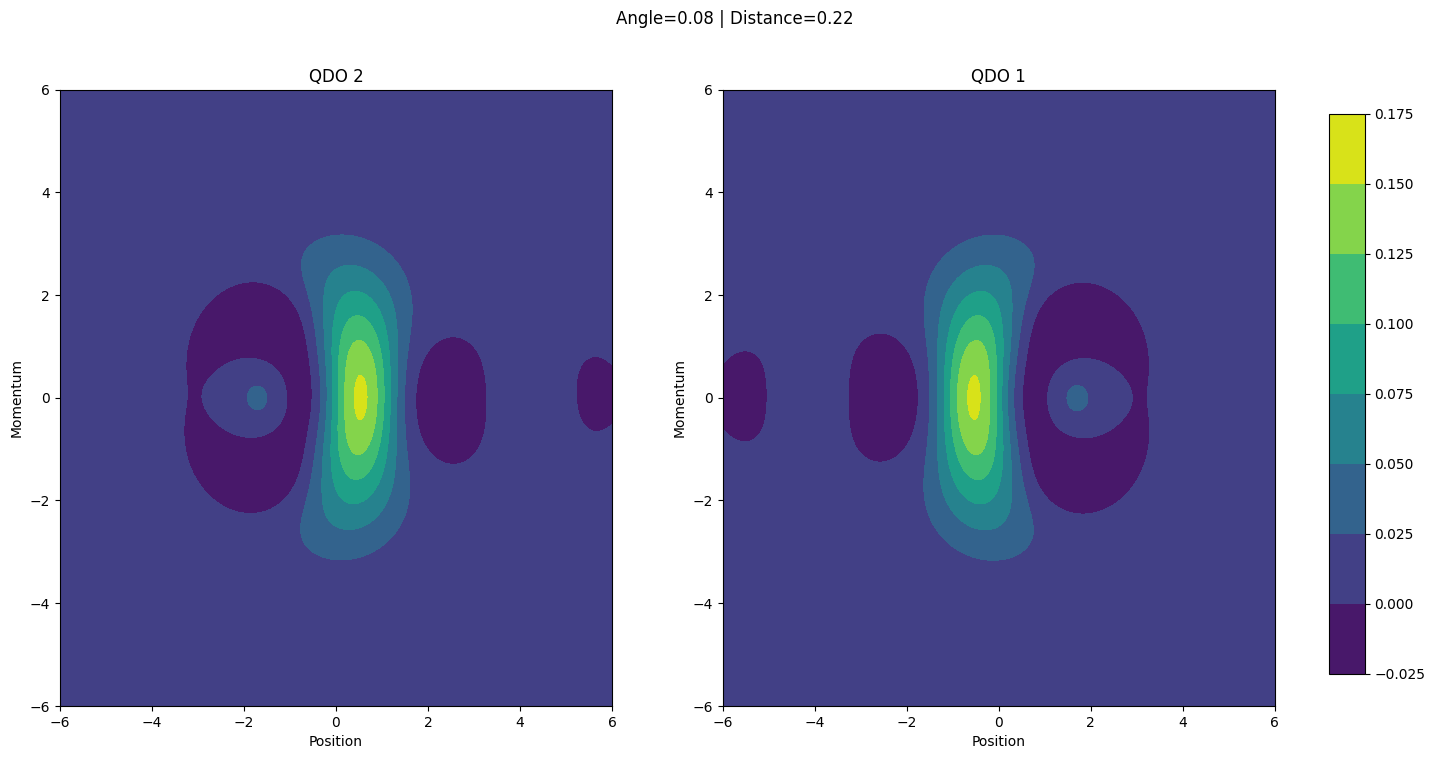

In [4]:
plot_wigner(
    fig_dir=None,
    quadrature_grid=quadrature_grid,
    thetas=thetas,
    distances=distances,
    angle_idx=1,
    distance_idx=7,
    states=states,
    cutoff_dim=args['cutoff_dim']
)

In [14]:
thetas[8]

0.6613879270715354

In [13]:
X, P = np.meshgrid(quadrature_grid, quadrature_grid)

angle = 8
fig_dir = os.path.join(dir, 'figures', 'wigner', 'angle={:.4f}'.format(thetas[angle]))

for distance in range(distances.shape[0]):
   
    plot_wigner(
        fig_dir=fig_dir,
        quadrature_grid=quadrature_grid,
        thetas=thetas,
        distances=distances,
        angle_idx=angle,
        distance_idx=distance,
        states=states,
        cutoff_dim=args['cutoff_dim'],
    )

make_gif(
    frames_dir=fig_dir,
    duration=20
)



2023-02-22 15:03:57.770601: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-22 15:03:57.770839: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-22 15:03:57.770856: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (uni-OptiPlex-7480-AIO): /proc/driver/nvidia/version does not exist
2023-02-22 15:03:57.772192: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Moviepy - Building video logs/2023.02.21.13.19.23/figures/wigner/angle=0.6614/animation.mp4.
Moviepy - Writing video logs/2023.02.21.13.19.23/figures/wigner/angle=0.6614/animation.mp4



Moviepy - Done !
Moviepy - video ready logs/2023.02.21.13.19.23/figures/wigner/angle=0.6614/animation.mp4


### Joint density vizualization

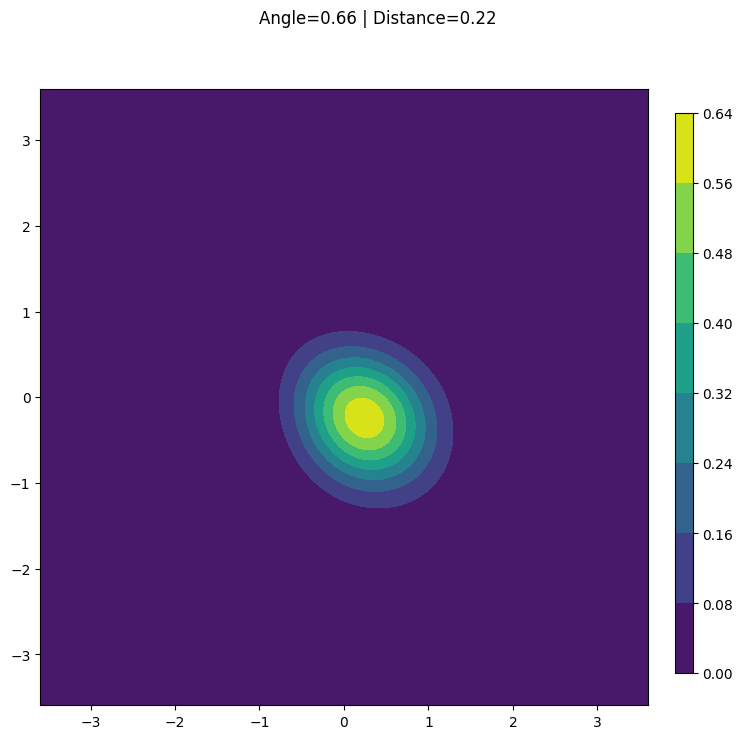

In [8]:
plot_joint_density(
    fig_dir=None,
    quadrature_grid=quadrature_grid[100: -100],
    thetas=thetas,
    distances=distances,
    angle_idx=8,
    distance_idx=7,
    states=states,
    cutoff_dim=args['cutoff_dim']
)

In [22]:
thetas[10]

0.8267349088394192

In [27]:
angle = 4
fig_dir = os.path.join(dir, 'figures', 'joint_density', 'angle={:.4f}'.format(thetas[angle]))

for distance in range(distances.shape[0]):
   
    plot_joint_density(
        fig_dir=fig_dir,
        quadrature_grid=quadrature_grid[100: -100],
        thetas=thetas,
        distances=distances,
        angle_idx=angle,
        distance_idx=distance,
        states=states,
        cutoff_dim=args['cutoff_dim']
    )

make_gif(
    frames_dir=fig_dir,
    duration=20
)

Moviepy - Building video logs/2023.02.21.13.19.23/figures/joint_density/angle=0.3307/animation.mp4.
Moviepy - Writing video logs/2023.02.21.13.19.23/figures/joint_density/angle=0.3307/animation.mp4



Moviepy - Done !
Moviepy - video ready logs/2023.02.21.13.19.23/figures/joint_density/angle=0.3307/animation.mp4


### Interpolation binding curve with Morse potential

Mathematica gives us the following Morse potential fit. Let us recall that the Morse potential is given by
$D_e(\exp(-2 a (r - r_e)) - 2 \exp(-a (r - r_e)))$

In [4]:
startingDistance = [1, 2, 3, 5, 7, 8, 10, 12, 15, 18, 24, 22, 18, 17, 17, 16, 21, 25, 24] # starting at the first non-parallel angle

In [5]:
from math import exp

def interpolation_morse(r, angle_idx):
    r'''
    These are the Morse potential fit obtained in Mathematica
    '''
    
    if angle_idx == 1:
        expr = 5.580390309448237*(exp(-3.0377471897088193*(-0.528669782788294 + r)) - 2/exp(1.5188735948544096*(-0.528669782788294 + r)))
    elif angle_idx == 2:
        expr = 3.4274486627573997*(exp(-3.799380158605931*(-0.47973290114432926 + r)) - 2/exp(1.8996900793029654*(-0.47973290114432926 + r)))
    elif angle_idx == 3:
        expr = 2.285401169096024*(exp(-4.402463155249511*(-0.4631079255337017 + r)) - 2/exp(2.2012315776247555*(-0.4631079255337017 + r)))
    elif angle_idx == 4:
        expr = 1.551192171427588*(exp(-4.81570374860555*(-0.4642655447957261 + r)) - 2/exp(2.407851874302775*(-0.4642655447957261 + r)))
    elif angle_idx == 5:
        expr = 1.0598470742964785*(exp(-5.1410754088615755*(-0.4783898190284267 + r)) - 2/exp(2.5705377044307878*(-0.4783898190284267 + r)))
    elif angle_idx == 6:
        expr = 0.7148220809706628*(exp(-5.3904241278507286*(-0.5018955265663114 + r)) - 2/exp(2.6952120639253643*(-0.5018955265663114 + r)))
    elif angle_idx == 7:
        expr = 0.46331721539795195*(exp(-5.5069105743552305*(-0.5384565406606292 + r)) - 2/exp(2.7534552871776152*(-0.5384565406606292 + r)))
    elif angle_idx == 8:
        expr = 0.28495211368558043*(exp(-5.501660360933069*(-0.5868720195028256 + r)) - 2/exp(2.7508301804665347*(-0.5868720195028256 + r)))
    elif angle_idx == 9:
        expr = 0.16054553861792828*(exp(-5.406762370032314*(-0.6589019567964931 + r)) - 2/exp(2.703381185016157*(-0.6589019567964931 + r)))
    elif angle_idx == 10:
        expr = 0.0802423625900907*(exp(-5.2807411035440905*(-0.7610680973692473 + r)) - 2/exp(2.6403705517720453*(-0.7610680973692473 + r)))
    elif angle_idx == 11:
        expr = 0.031941895762222915*(exp(-4.8881023079372845*(-0.9318352120398004 + r)) - 2/exp(2.4440511539686423*(-0.9318352120398004 + r)))
    elif angle_idx == 12:
        expr = -0.21795992863678978*(exp(-18.93357243882598*(-0.419031099683263 + r)) - 2/exp(9.46678621941299*(-0.419031099683263 + r)))
    elif angle_idx == 13:
        expr = -4.596185038513766e8*(exp(-11.486738219445648*(3.3611808687392295 + r)) - 2/exp(5.743369109722824*(3.3611808687392295 + r)))
    elif angle_idx == 14:
        expr = -8.435877205314344e8*(exp(-9.835982910255005*(4.090374604186538 + r)) - 2/exp(4.917991455127503*(4.090374604186538 + r)))
    elif angle_idx == 15:
        expr = -5595.4996148289965*(-2*exp(3.473725867625206e-6*(199537.59265461436 + r)) + exp(6.947451735250412e-6*(199537.59265461436 + r)))
    elif angle_idx == 16:
        expr = -6257.5024012085705*(-2*exp(3.613860552846493e-6*(191800.01322388317 + r)) + exp(7.227721105692986e-6*(191800.01322388317 + r)))
    elif angle_idx == 17:
        expr = -78.2709544530638*(exp(-7.326961784623224*(1.1821855753944306 + r)) - 2/exp(3.663480892311612*(1.1821855753944306 + r)))
    elif angle_idx == 18:
        expr = -60.335480736907535*(exp(-6.655169258297058*(1.283760988719811 + r)) - 2/exp(3.327584629148529*(1.283760988719811 + r)))
    elif angle_idx == 19:
        expr = -59.1291656257202*(exp(-6.735608158749974*(1.248561482832166 + r)) - 2/exp(3.367804079374987*(1.248561482832166 + r)))
    return expr

In [52]:
def plot_binding_curve_morse(
    distance_array: np.ndarray,
    binding_energy_array: np.ndarray,
    angle_idx: int,
    ymin: Optional[float]=None,
    ymax: Optional[float]=None
) -> None:

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))

    axes.plot(
        np.linspace(0.1, 3.7, 100), 
        [interpolation_morse(r, angle_idx) for r in np.linspace(0.1, 3.7, 100)], 
        c='orange',
        alpha=0.7
    )

    axes.scatter(
        distance_array[startingDistance[angle_idx-1]::3], 
        binding_energy_array[angle_idx, startingDistance[angle_idx-1]::3], 
        s=20, 
        c='darkblue', 
        marker='*',
        alpha=0.7
    )
    
    axes.set_xlabel('Interatomic distance')
    axes.set_ylabel('Binding energy')
    if ymin is not None and ymax is not None:
        axes.set_ylim(ymin, ymax)
    axes.grid(True)
    axes.set_title('Binding energy for a pair of QDOs')
    plt.show()
    #plt.savefig(save_path, dpi=300, transparent=False, bbox_inches='tight')

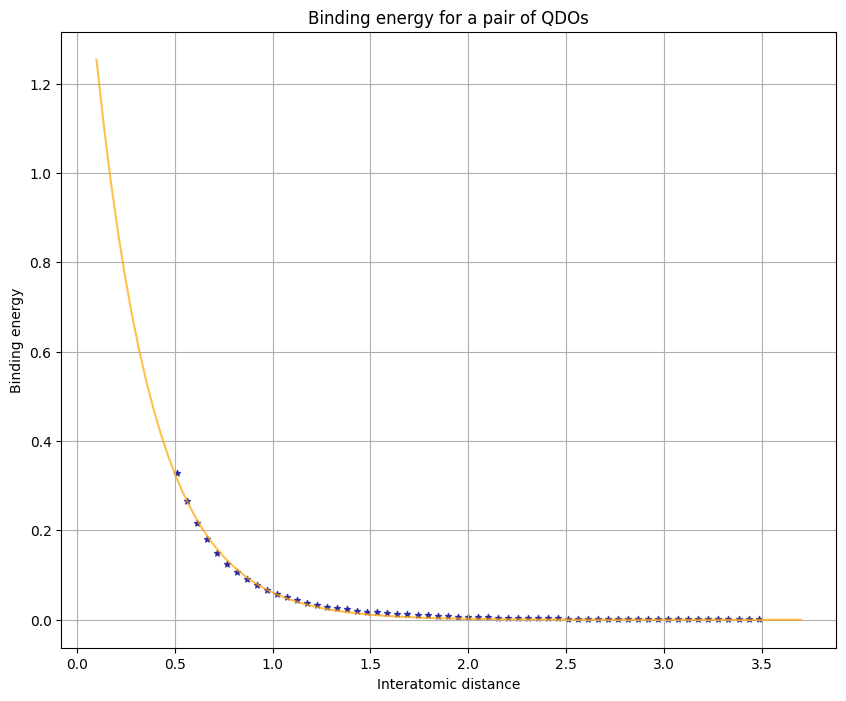

In [74]:
plot_binding_curve_morse(
    distance_array=distances,
    binding_energy_array=binding_energies,
    angle_idx=19
)

In [19]:
from math import sqrt

def loss_morse(
    distance_array: np.ndarray,
    binding_energy_array: np.ndarray,
    angle_idx: int
) -> float:

    distances = distance_array[startingDistance[angle_idx-1]:]
    energies = binding_energy_array[angle_idx, startingDistance[angle_idx-1]:]

    l = 0

    for i in range(distances.shape[0]):
        l += (energies[i] - interpolation_morse(distances[i], angle_idx))**2

    return sqrt(l)

In [20]:
fit_quality_list = []

for angle_idx in range(1, thetas.shape[0]):
    l = loss_morse(
        distance_array=distances,
        binding_energy_array=binding_energies,
        angle_idx=angle_idx
    )

    fit_quality_list.append(l)
    

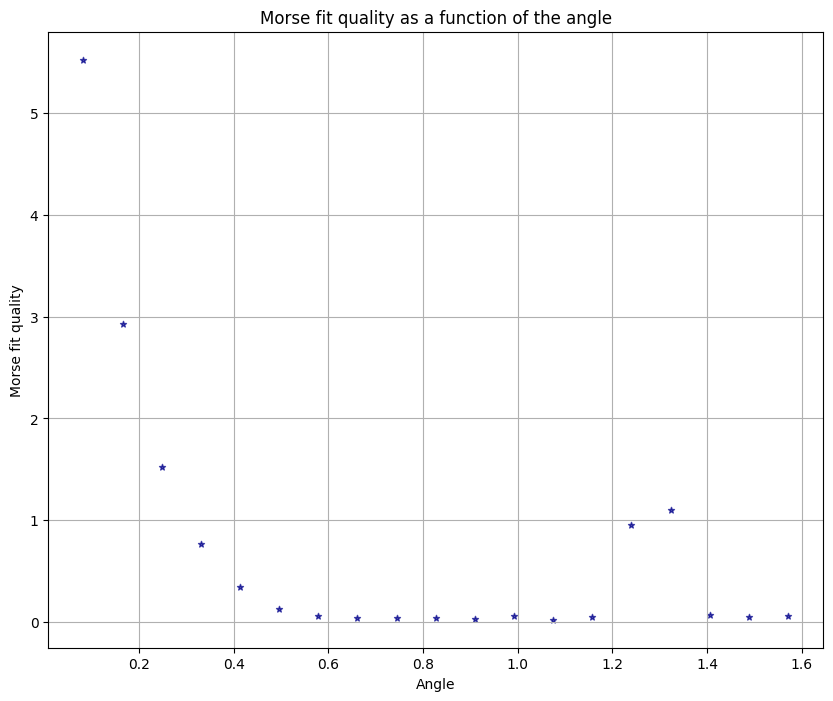

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))

axes.scatter(
    thetas[1:], 
    fit_quality_list, 
    s=20, 
    c='darkblue', 
    marker='*',
    alpha=0.7
)

axes.set_xlabel('Angle')
axes.set_ylabel('Morse fit quality')
axes.grid(True)
axes.set_title('Morse fit quality as a function of the angle')
plt.show()
#plt.savefig(save_path, dpi=300, transparent=False, bbox_inches='tight')

In [26]:
mathematica_dir = os.path.join('mathematica', dir.split('/')[1])
os.makedirs(mathematica_dir, exist_ok=True)
np.array(fit_quality_list).astype('float32').tofile(os.path.join(mathematica_dir, 'morse_fit_quality.dat'))

Mathematica gives us the following exponential fit (ignoring the two weird points)

In [27]:
def fit_morse_quality(r):
    return 10.698201438598309/exp(7.941329322829148*r)

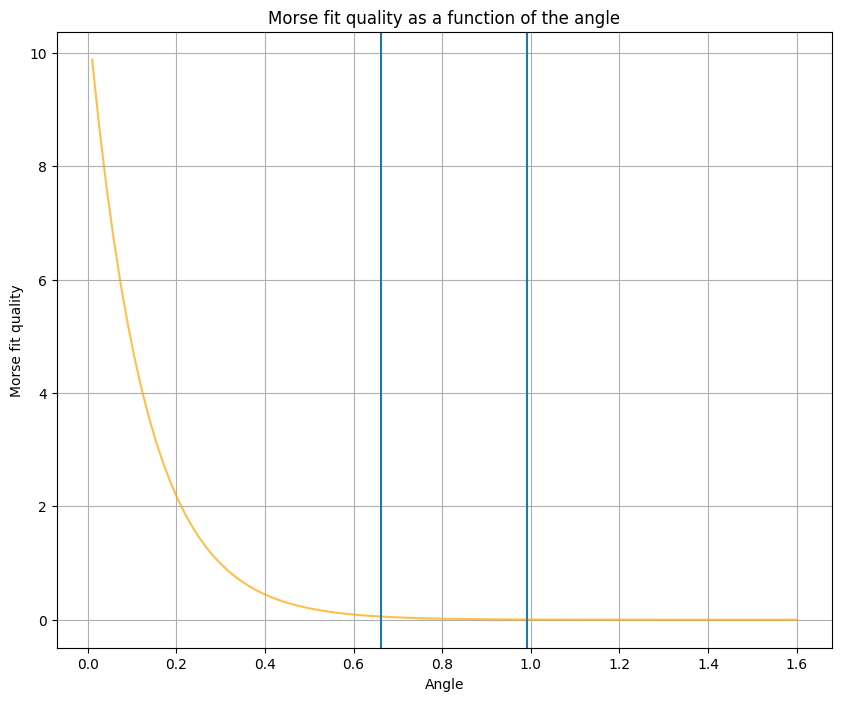

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))

axes.plot(
    np.linspace(0.01, 1.6, 100), 
    [fit_morse_quality(r) for r in np.linspace(0.01, 1.6, 100)], 
    c='orange',
    alpha=0.7
)

axes.axvline(x=0.6613879270715354)
axes.axvline(x=0.992081890607303)

axes.set_xlabel('Angle')
axes.set_ylabel('Morse fit quality')
axes.grid(True)
axes.set_title('Morse fit quality as a function of the angle')
plt.show()
#plt.savefig(save_path, dpi=300, transparent=False, bbox_inches='tight')

We see that the angle should be larger than 0.6 (namely angle_idx >= 8 in python conventions).
Also angle_idx <= 12 to have binding.

In [46]:
thetas[8], thetas[12]


(0.6613879270715354, 0.992081890607303)

### Interpolation binding curve with Lennard-Jones potential

Mathematica gives us the following Morse potential fit. Let us recall that the Lennard-Jones potential is given by
$4\epsilon\left(\left(\frac{\sigma}{r}\right)^{12}-\left(\frac{\sigma}{r}\right)^{6}\right)$.

Spoiler: Lennard-Jones doesn't fit the data at all, for any angle.

In [6]:
startingDistance = [1, 2, 3, 5, 7, 8, 10, 12, 15, 18, 24, 22, 18, 17, 17, 16, 21, 25, 24] # starting at the first non-parallel angle

In [7]:
from math import exp

def interpolation_lennard(r, angle_idx):
    r'''
    These are the Lennard-Jones potential fit obtained in Mathematica
    '''
    
    if angle_idx == 1:
        expr = 14.28437437638727*(1.0641815684465783e-12/r**12 - 1.031591764433285e-6/r**6)
    elif angle_idx == 2:
        expr = 7.452182411564902*(7.56245431851208e-12/r**12 - 2.749991694262381e-6/r**6)
    elif angle_idx == 3:
        expr = 4.128152479333588*(4.523534696575e-11/r**12 - 6.7257227838909635e-6/r**6)
    elif angle_idx == 4:
        expr = 3.9105012462172604*(6.30407424586663e-10/r**12 - 0.000025107915576301087/r**6)
    elif angle_idx == 5:
        expr = 3.162716721430049*(5.792809985250989e-9/r**12 - 0.00007611051166068316/r**6)
    elif angle_idx == 6:
        expr = 1.7072510773839054*(1.8619201372275537e-8/r**12 - 0.00013645219445752982/r**6)
    elif angle_idx == 7:
        expr = 1.118348840529785*(1.1527071946255388e-7/r**12 - 0.00033951541859325606/r**6)
    elif angle_idx == 8:
        expr = -1.250578080868312e8*(2.5038620641639665e-26/r**12 - 1.5823596507001708e-13/r**6)
    elif angle_idx == 9:
        expr = 0.3224592914723465*(5.231045235782126e-6/r**12 - 0.00228714783863705/r**6)
    elif angle_idx == 10:
        expr = 0.06286771881566044*(0.00006943827678395015/r**12 - 0.008332963265486664/r**6)
    elif angle_idx == 11:
        expr = 0.010606969789519534*(0.0030789596949579983/r**12 - 0.0554883744126461/r**6)
    elif angle_idx == 12:
        expr = -0.8079722229652286*(0.00001814766305310765/r**12 - 0.004260007400593061/r**6)
    elif angle_idx == 13:
        expr = -1.6038810067475535*(5.274223090060965e-6/r**12 - 0.0022965676759157273/r**6)
    elif angle_idx == 14:
        expr = -2.0758619143330552*(3.5425374582588847e-6/r**12 - 0.0018821629733524368/r**6)
    elif angle_idx == 15:
        expr = -2.304453533688181*(3.790591183985918e-6/r**12 - 0.0019469440628805744/r**6)
    elif angle_idx == 16:
        expr = -2.7344211489193024*(2.2244020238864366e-6/r**12 - 0.0014914429334997828/r**6)
    elif angle_idx == 17:
        expr = -1.772552699150137*(0.00002927796413500143/r**12 - 0.0054109115807783655/r**6)
    elif angle_idx == 18:
        expr = -1.3157568211630397*(0.00016351084273747576/r**12 - 0.012787135830101898/r**6)
    elif angle_idx == 19:
        expr = -1.4418368701037456*(0.00010921335590614043/r**12 - 0.010450519408438053/r**6)
    return expr

In [17]:
def plot_binding_curve_lennard(
    distance_array: np.ndarray,
    binding_energy_array: np.ndarray,
    angle_idx: int,
    ymin: Optional[float]=None,
    ymax: Optional[float]=None
) -> None:

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))

    axes.plot(
        np.linspace(0.4, 3.7, 100), 
        [interpolation_lennard(r, angle_idx) for r in np.linspace(0.4, 3.7, 100)], 
        c='orange',
        alpha=0.7
    )

    axes.scatter(
        distance_array[startingDistance[angle_idx-1]::3], 
        binding_energy_array[angle_idx, startingDistance[angle_idx-1]::3], 
        s=20, 
        c='darkblue', 
        marker='*',
        alpha=0.7
    )
    
    axes.set_xlabel('Interatomic distance')
    axes.set_ylabel('Binding energy')
    if ymin is not None and ymax is not None:
        axes.set_ylim(ymin, ymax)
    axes.grid(True)
    axes.set_title('Binding energy for a pair of QDOs')
    plt.show()
    #plt.savefig(save_path, dpi=300, transparent=False, bbox_inches='tight')

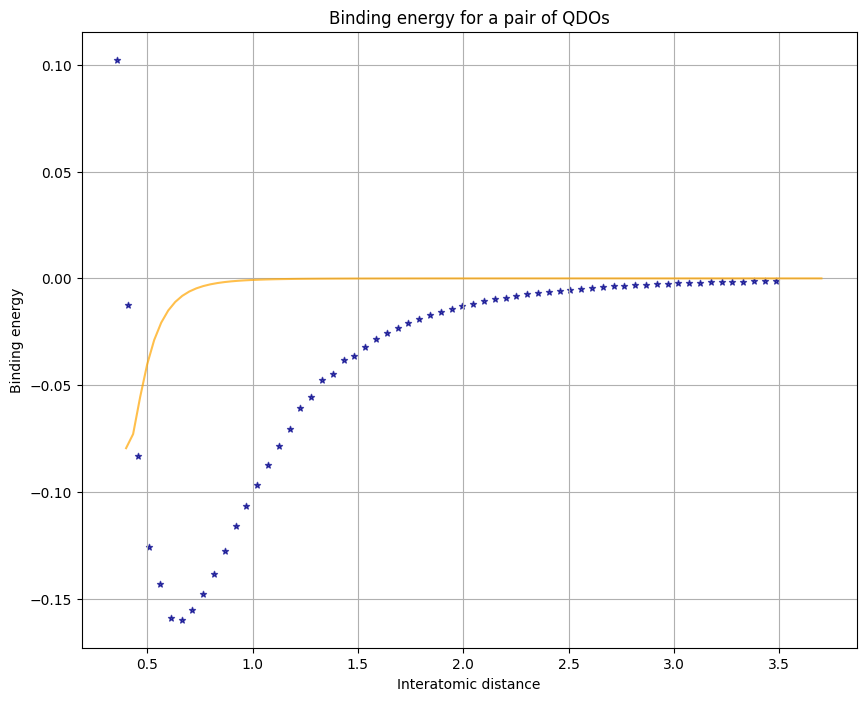

In [20]:
plot_binding_curve_lennard(
    distance_array=distances,
    binding_energy_array=binding_energies,
    angle_idx=9
)

In [12]:
from math import sqrt

def loss_lennard(
    distance_array: np.ndarray,
    binding_energy_array: np.ndarray,
    angle_idx: int
) -> float:

    distances = distance_array[startingDistance[angle_idx-1]:]
    energies = binding_energy_array[angle_idx, startingDistance[angle_idx-1]:]

    l = 0

    for i in range(distances.shape[0]):
        l += (energies[i] - interpolation_lennard(distances[i], angle_idx))**2

    return sqrt(l)

In [13]:
fit_quality_list = []

for angle_idx in range(1, thetas.shape[0]):
    l = loss_lennard(
        distance_array=distances,
        binding_energy_array=binding_energies,
        angle_idx=angle_idx
    )

    fit_quality_list.append(l)
    

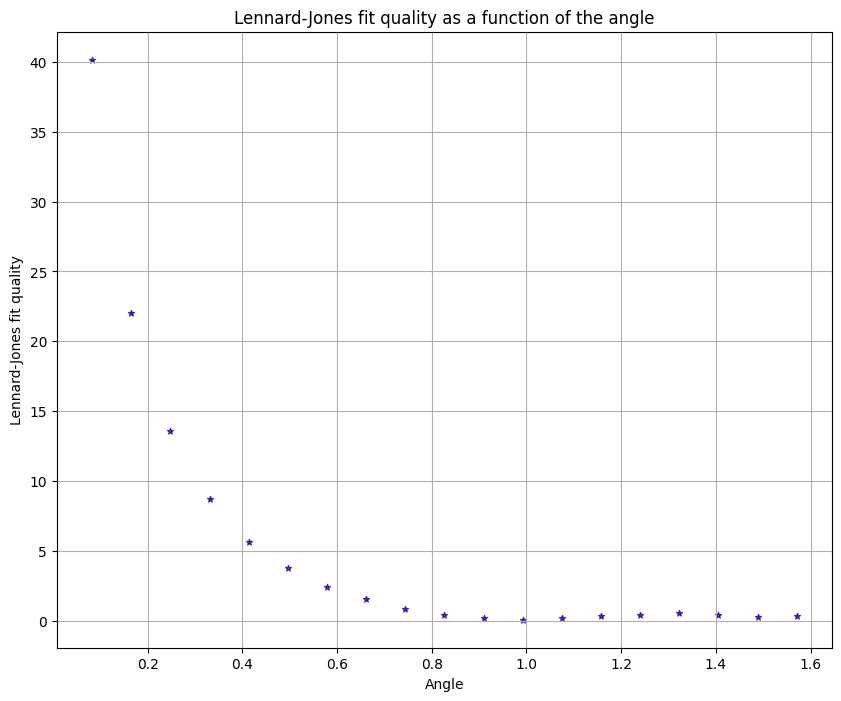

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))

axes.scatter(
    thetas[1:], 
    fit_quality_list, 
    s=20, 
    c='darkblue', 
    marker='*',
    alpha=0.7
)

axes.set_xlabel('Angle')
axes.set_ylabel('Lennard-Jones fit quality')
axes.grid(True)
axes.set_title('Lennard-Jones fit quality as a function of the angle')
plt.show()
#plt.savefig(save_path, dpi=300, transparent=False, bbox_inches='tight')